Try to read and make the best from the dataset

In [100]:
import numpy as np
import pandas as pd

df = pd.read_csv('scrambled-CMBDAH 2021-23.csv', sep=';')

df.head(5)

### Dades reals mes d'un episodi per pacient, cada episodi es independent y no es acumulatiu. Fer una unió dels episodis més frecuents. 

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\3740417299.py:4: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('scrambled-CMBDAH 2021-23.csv', sep=';')


,Id_pacient,Data_naix,Edat,Sexe,Data_ingres,Circ_admiss,Procedencia ingres,Data_alta,Circ_alta,Dies_estada,...,POA5,POA6,POA7,POA8,POA9,POA10,POA11,POA12,POA13,POA14
0,nncSYRRHFA==,15/09/1958 0:00,62,0,29/12/2020 14:20,1,8,01/01/2021 1:31,1,3,...,S,S,S,S,S,E,E,NaN,NaN,NaN
1,nncSYRtCHg==,15/06/1977 0:00,43,0,30/12/2020 8:39,1,8,01/01/2021 9:44,6,2,...,S,S,S,S,NaN,NaN,NaN,NaN,NaN,NaN
2,nncSZRtDFA==,11/01/1940 0:00,80,0,23/12/2020 23:39,1,8,01/01/2021 10:27,6,9,...,S,S,S,E,E,E,E,E,NaN,NaN
3,nncSYBFBEA==,03/03/1960 0:00,60,1,28/12/2020 16:36,1,8,01/01/2021 10:52,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nncRbRZHHg==,02/08/1937 0:00,83,0,22/12/2020 14:46,1,8,01/01/2021 11:56,1,10,...,S,S,S,S,S,S,S,S,S,S


**Agrupación episodios por paciente**

In [101]:
import pandas as pd

# Cargando los datos desde el archivo CSV proporcionado
file_path = 'scrambled-CMBDAH 2021-23 episodes.csv'
df = pd.read_csv(file_path, sep=';', low_memory=False)  # Usando low_memory=False para evitar problemas de tipos de datos

# Limpiando y convirtiendo la columna 'Data_naix' a tipo fecha sin la hora para asegurar consistencia
df['Data_naix'] = pd.to_datetime(df['Data_naix'], dayfirst=True).dt.date  # Asegurando el formato correcto de fecha

# Agrupando los datos por 'Data_naix' y 'Sexe' y asignando el 'Id_pacient' del primer episodio encontrado en cada grupo
df['Id_pacient'] = df.groupby(['Data_naix', 'Sexe'])['Id_pacient'].transform('first')

# Guardando el DataFrame modificado en un archivo CSV nuevo
output_path_modified = 'modified_CMBDAH_2021_23_episodes.csv'
df.to_csv(output_path_modified,  sep=';', index=False)

# Imprimir la ruta del archivo guardado para que el usuario sepa dónde encontrarlo
print("DataFrame completo con IDs modificados guardado en:", output_path_modified)


DataFrame completo con IDs modificados guardado en: modified_CMBDAH_2021_23_episodes.csv


**Transformaciones a los episodios: codificación diagnosticos acorde con POA, filtrado y agrupación de diagnosticos y tratamientos segun presencia (no podemos cojer todos para el OHE)**

In [102]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Cargar datos
df = pd.read_csv('modified_CMBDAH_2021_23_episodes.csv', sep=';')

#Definir frecuencia significativa
frecuence = 0.0005

# Modificar DP y DSx para incluir indicadores POA
df['DP'] = df.apply(lambda row: f"{row['DP']}-S" if row['POAP'] == 'S' else (f"{row['DP']}-N" if row['POAP'] == 'N' else None), axis=1)

# Modificar todos los diagnósticos secundarios (DSx)
for i in range(1, 15):
    df[f'DS{i}'] = df.apply(lambda row: f"{row[f'DS{i}']}-S" if row[f'POA{i}'] == 'S' else (f"{row[f'DS{i}']}-N" if row[f'POA{i}'] == 'N' else None), axis=1)

# Agrupar todos los diagnósticos secundarios en una lista
df['other_diagnostics'] = df[['DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14']].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)

# Agrupar por 'Id_pacient', consolidando diagnósticos
df_grouped_diagnostics = df.groupby('Id_pacient').agg({
    'DP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,  # Tomar el DP más frecuente o el primer valor si hay empate
    'other_diagnostics': lambda x: [item for sublist in x for item in sublist]  # Unir todos los diagnósticos secundarios
}).reset_index()

# Juntar DP y diagnósticos secundarios para hacer el análisis de frecuencia
all_diagnostics = [diag for sublist in df_grouped_diagnostics['other_diagnostics'] for diag in sublist] + df_grouped_diagnostics['DP'].dropna().tolist()

# Contar frecuencia de diagnósticos
diagnostic_counts = pd.Series(all_diagnostics).value_counts(normalize=True)
significant_diagnostics = diagnostic_counts[diagnostic_counts > frecuence].index  # Mantener solo los diagnósticos más frecuentes (>1%)

# Filtrar DP y otros diagnósticos significativos
df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: x if x in significant_diagnostics else None)
df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: [diag for diag in x if diag in significant_diagnostics])

# Si no hay diagnósticos significativos, agregar un diagnóstico vacío para evitar filas vacías en el OHE
df_grouped_diagnostics['DP'] = df_grouped_diagnostics['DP'].apply(lambda x: [x] if pd.notnull(x) else [])
df_grouped_diagnostics['other_diagnostics'] = df_grouped_diagnostics['other_diagnostics'].apply(lambda x: x if len(x) > 0 else ['No_Diagnosis'])

# Repetir el mismo proceso para tratamientos
df['PP'] = df['PP'].apply(lambda x: x if pd.notnull(x) else None)

# Agrupar todos los tratamientos secundarios (PSx)
df['other_treatments'] = df[['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14']].apply(lambda x: [i for i in x if pd.notnull(i)], axis=1)

# Agrupar por 'Id_pacient', consolidando tratamientos
df_grouped_treatments = df.groupby('Id_pacient').agg({
    'PP': lambda x: pd.Series.mode(x)[0] if not x.isna().all() else None,  # Tomar el tratamiento principal más frecuente o el primer valor si hay empate
    'other_treatments': lambda x: [item for sublist in x for item in sublist]  # Unir todos los tratamientos secundarios
}).reset_index()

# Juntar PP y tratamientos secundarios para hacer el análisis de frecuencia
all_treatments = [treat for sublist in df_grouped_treatments['other_treatments'] for treat in sublist] + df_grouped_treatments['PP'].dropna().tolist()

# Contar frecuencia de tratamientos
treatment_counts = pd.Series(all_treatments).value_counts(normalize=True)
significant_treatments = treatment_counts[treatment_counts > frecuence].index  # Mantener solo los tratamientos más frecuentes (>1%)

# Filtrar PP y otros tratamientos significativos
df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: x if x in significant_treatments else None)
df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: [treat for treat in x if treat in significant_treatments])

# Si no hay tratamientos significativos, agregar un tratamiento vacío para evitar filas vacías en el OHE
df_grouped_treatments['PP'] = df_grouped_treatments['PP'].apply(lambda x: [x] if pd.notnull(x) else [])
df_grouped_treatments['other_treatments'] = df_grouped_treatments['other_treatments'].apply(lambda x: x if len(x) > 0 else ['No_Treatment'])

# Aplicar One-Hot Encoding para diagnósticos y tratamientos
mlb_diagnostics = MultiLabelBinarizer()
diagnostics_encoded = mlb_diagnostics.fit_transform(df_grouped_diagnostics['DP'] + df_grouped_diagnostics['other_diagnostics'])
diagnostics_df = pd.DataFrame(diagnostics_encoded, columns=mlb_diagnostics.classes_)

mlb_treatments = MultiLabelBinarizer()
treatments_encoded = mlb_treatments.fit_transform(df_grouped_treatments['PP'] + df_grouped_treatments['other_treatments'])
treatments_df = pd.DataFrame(treatments_encoded, columns=mlb_treatments.classes_)

# Concatenar los resultados de diagnósticos y tratamientos
df_combined = pd.concat([df_grouped_diagnostics['Id_pacient'], diagnostics_df, treatments_df], axis=1)

# Guardar el resultado en un archivo CSV
output_path = 'final_ohe_patients.csv'
df_combined.to_csv(output_path, sep=';', index=False)
print(f"Resultado guardado en {output_path}")
print(df_combined.shape)

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\1369673125.py:5: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('modified_CMBDAH_2021_23_episodes.csv', sep=';')


Resultado guardado en final_ohe_patients.csv
(31578, 551)


In [103]:

# Extraer las columnas correspondientes a diagnósticos y tratamientos codificados
diagnostics_encoded = diagnostics_df.values  # Convertir a array de numpy
treatments_encoded = treatments_df.values    # Convertir a array de numpy

# Concatenar las matrices horizontales (One-Hot Encodings)
X = np.hstack((diagnostics_encoded, treatments_encoded))

# Mostrar una muestra del resultado
print(X[:5])

# Verificar las dimensiones de X
print(f"Dimensiones de X: {X.shape}")


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Dimensiones de X: (31578, 550)


**Clusterización pacientes**

In [104]:
import CoreFunctions as cf

k = 20           #k is the number of clusters

#Run the proposed clustering algorithm 

#### Nomes estic fent el clustering amb els diagnostics, hauria de contemplar totes les altres variables? No
M,P,CL = cf.NaiveBayesClustering(X,k)

**Asignamos los clusters a cada episodio de cada paciente**

In [105]:
df = pd.read_csv('modified_CMBDAH_2021_23_episodes.csv', sep=';')

# Asegúrate de que la longitud del array de clusters coincide con el número de filas en df_combined
if len(CL) == len(df_combined):
    df_combined['cluster'] = CL
else:
    raise ValueError("La longitud del vector de clusters no coincide con el número de pacientes agrupados.")

# Ahora, une 'df_grouped' que contiene los clusters con el DataFrame original 'df' usando 'Id_pacient'
# Unimos la información de cluster al DataFrame original 'df' usando 'Id_pacient'
df_cluster = df.merge(df_combined[['Id_pacient', 'cluster']], on='Id_pacient', how='left')
df_cluster.to_csv('data_cluster.csv', sep=';', index=False)

df_cluster.head()
print(df_cluster.shape)


C:\Users\34676\AppData\Local\Temp\ipykernel_14416\2364802178.py:1: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('modified_CMBDAH_2021_23_episodes.csv', sep=';')


(67976, 60)


In [106]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67976 entries, 0 to 67975
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id_pacient          67976 non-null  object
 1   Data_naix           67976 non-null  object
 2   Edat                67976 non-null  int64 
 3   Sexe                67976 non-null  int64 
 4   Data_ingres         67976 non-null  object
 5   Circ_admiss         67976 non-null  int64 
 6   Procedencia ingres  67976 non-null  int64 
 7   Data_alta           67976 non-null  object
 8   Circ_alta           67976 non-null  int64 
 9   Dies_estada         67976 non-null  int64 
 10  Servei_alta         67976 non-null  int64 
 11  Descr_Servei-alta   67976 non-null  object
 12  DRG                 67976 non-null  int64 
 13  T. asist.           67976 non-null  int64 
 14  DP                  67974 non-null  object
 15  DS1                 54147 non-null  object
 16  DS2                 46

**Extracción de mètricas por cluster**

In [107]:
import pandas as pd
import numpy as np
from collections import Counter

# Obtiene los clusters únicos
clusters = df_cluster['cluster'].unique()
cluster_frequencies = df_cluster['cluster'].value_counts(normalize=True)  # Normalizado para obtener la proporción

# Preparar el diccionario para almacenar las métricas por cluster
cluster_metrics = {}
import pandas as pd
import numpy as np
from collections import Counter

# Función para detectar valores faltantes (tanto NaN como vacíos)
def calculate_missing_metrics(df, columns):
    """
    Calculate the proportion of missing values in the specified columns (i.e., NaN or empty).
    """
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

# Función para obtener los diagnósticos más frecuentes con frecuencias relativas
def get_top_n_diagnoses_with_poa_suffix_v2(df, diagnosis_columns, poa_columns, n=8, separate_DP=False):
    count_series_secondary = pd.Series(dtype=int)
    count_series_DP = pd.Series(dtype=int)
    missing_count_DP = 0
    missing_count_secondary = 0
    total_count_DP = 0
    total_count_secondary = 0

    # Diccionario de sufijos para los códigos POA
    poa_suffix_map = {
        'S': '-S',
        'N': '-N',
        'D': '-D',
        'I': '-I',
        'E': '-E'
    }

    # Si separamos el diagnóstico principal (DP)
    if separate_DP:
        df.loc[:, 'DP'] = df.apply(lambda row: f"{row['DP']}{poa_suffix_map.get(row['POAP'], '')}" if pd.notnull(row['DP']) and row['DP'] != '' else None, axis=1)
        
        # Contar diagnósticos principales (DP)
        count_series_DP = df['DP'].value_counts()
        total_count_DP = len(df['DP'])
        missing_count_DP = df['DP'].isnull().sum() + (df['DP'] == '').sum()  # Contar vacíos como missing

        # Excluir DP para procesar diagnósticos secundarios
        diagnosis_columns = diagnosis_columns[1:]
        poa_columns = poa_columns[1:]

    # Combinar todos los diagnósticos secundarios
    for diag_col, poa_col in zip(diagnosis_columns, poa_columns):
        df.loc[:, diag_col] = df.apply(lambda row: f"{row[diag_col]}{poa_suffix_map.get(row[poa_col], '')}" if pd.notnull(row[diag_col]) and row[diag_col] != '' else None, axis=1)
        
        # Contar diagnósticos secundarios
        missing_count_secondary += df[diag_col].isnull().sum() + (df[diag_col] == '').sum()  # Contar vacíos como missing
        count_series_secondary = count_series_secondary.add(df[diag_col].value_counts(), fill_value=0)
        total_count_secondary += len(df[diag_col])

    # Convertir las cuentas en frecuencias relativas
    dp_top_n = count_series_DP.nlargest(n)
    dp_top_n_rel = dp_top_n / dp_top_n.sum()

    secondary_top_n = count_series_secondary.nlargest(n)
    secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()

    # Proporción de valores faltantes
    missing_proportion_DP = missing_count_DP / total_count_DP if total_count_DP > 0 else 0
    missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0

    results = {
        'DP': dp_top_n_rel.to_dict(),
        'other_diagnoses': secondary_top_n_rel.to_dict(),
        'missing_DP': missing_proportion_DP,
        'missing_secondary': calculate_missing_metrics(cluster_data, diagnosis_columns)
    }
    
    return results

# Función para obtener los tratamientos más frecuentes con frecuencias relativas
def get_top_n_treatments_with_missing_v2(df, treatment_columns, n=100, separate_PP=False):
    count_series_secondary = pd.Series(dtype=int)
    count_series_PP = pd.Series(dtype=int)
    missing_count_PP = 0
    missing_count_secondary = 0
    total_count_PP = 0
    total_count_secondary = 0

    # Si separamos el tratamiento principal (PP)
    if separate_PP:
        count_series_PP = df['PP'].value_counts()
        total_count_PP = len(df['PP'])
        missing_count_PP = df['PP'].isnull().sum() + (df['PP'] == '').sum()

        # Excluir PP para procesar los tratamientos secundarios
        treatment_columns = treatment_columns[1:]

    # Combinar todos los tratamientos secundarios
    for treatment_col in treatment_columns:
        missing_count_secondary += df[treatment_col].isnull().sum() + (df[treatment_col] == '').sum()
        count_series_secondary = count_series_secondary.add(df[treatment_col].value_counts(), fill_value=0)
        total_count_secondary += len(df[treatment_col])

    pp_top_n = count_series_PP.nlargest(n)
    pp_top_n_rel = pp_top_n / pp_top_n.sum()

    secondary_top_n = count_series_secondary.nlargest(n)
    secondary_top_n_rel = secondary_top_n / secondary_top_n.sum()

    missing_proportion_PP = missing_count_PP / total_count_PP if total_count_PP > 0 else 0
    missing_proportion_secondary = missing_count_secondary / total_count_secondary if total_count_secondary > 0 else 0

    results = {
        'PP': pp_top_n_rel.to_dict(),
        'other_treatments': secondary_top_n_rel.to_dict(),
        'missing_PP': missing_proportion_PP,
        'missing_secondary': calculate_missing_metrics(cluster_data, treatment_columns)
    }

    return results

# Función para obtener distribución cuantílica personalizada para variables continuas
def get_custom_binned_distribution(df, column, num_bins=20):
    col_range = df[column].max() - df[column].min()

    if col_range > 400:
        num_bins = 1000  # Ajustar el número de bins para valores amplios
    
    binned_series = pd.cut(df[column], bins=num_bins, include_lowest=True)
    binned_distribution = binned_series.value_counts(normalize=True, sort=False).to_dict()

    return binned_distribution

# Bucle principal para calcular las métricas por cluster
for cluster in clusters:
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]
    
    metrics = {'frecuencia_cluster': cluster_frequencies[cluster]}

    # Cálculo de proporciones de missing para tratamientos secundarios y diagnósticos secundarios
    diagnosis_columns = ['DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14']
    treatment_columns = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14']
    
    # metrics['missing_secondary_treatments'] = calculate_missing_metrics(cluster_data, treatment_columns)
    # metrics['missing_secondary_diagnoses'] = calculate_missing_metrics(cluster_data, diagnosis_columns)

    categorical_vars = ['Sexe', 'Circ_admiss', 'Procedencia ingres', 'Circ_alta', 'Servei_alta', 'Descr_Servei-alta', 'T. asist.']
    continuous_vars = ['Edat', 'Dies_estada', 'DRG']

    episode_counts = cluster_data['Id_pacient'].value_counts()
    metrics['episode_distribution'] = episode_counts.value_counts(normalize=True).to_dict()

    # Calcular frecuencias relativas para las variables categóricas
    for var in categorical_vars:
        metrics[var] = cluster_data[var].value_counts(normalize=True, dropna=False).to_dict()

        # Calcular distribución cuantílica para las variables continuas
    for var in continuous_vars:
        metrics[var] = get_custom_binned_distribution(cluster_data, var)

    # Diagnósticos más frecuentes y valores faltantes
    metrics['top_n_diagnoses_separated'] = get_top_n_diagnoses_with_poa_suffix_v2(
        cluster_data, 
        ['DP', 'DS1', 'DS2', 'DS3', 'DS4', 'DS5', 'DS6', 'DS7', 'DS8', 'DS9', 'DS10', 'DS11', 'DS12', 'DS13', 'DS14'],
        ['POAP', 'POA1', 'POA2', 'POA3', 'POA4', 'POA5', 'POA6', 'POA7', 'POA8', 'POA9', 'POA10', 'POA11', 'POA12', 'POA13', 'POA14'],
        n=200, separate_DP=True
    )

    # Tratamientos más frecuentes y valores faltantes
    metrics['top_n_treatments_separated'] = get_top_n_treatments_with_missing_v2(
        cluster_data, 
        ['PP', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9', 'PS10', 'PS11', 'PS12', 'PS13', 'PS14'],
        n=200, separate_PP=True
    )



    cluster_metrics[cluster] = metrics

# Mostrar resultados en el orden solicitado
for cluster, data in cluster_metrics.items():
    print(f"Cluster {cluster}:")
    for key, value in data.items():
        print(f"  {key}: {value}")
    print("\n")



C:\Users\34676\AppData\Local\Temp\ipykernel_14416\2646534917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
C:\Users\34676\AppData\Local\Temp\ipykernel_14416\2646534917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
C:\Users\34676\AppData\Local\Temp\ipykernel_14416\2646534917.py:20: SettingWithCopyWarning: 
A val

Cluster 13:
  frecuencia_cluster: 0.06596445804401553
  episode_distribution: {1: 0.656445763270689, 2: 0.240685789647214, 3: 0.07682162875041214, 4: 0.021760633036597428, 5: 0.002967359050445104, 6: 0.0009891196834817012, 7: 0.0003297065611605671}
  Sexe: {0: 0.5385816235504014, 1: 0.4614183764495986}
  Circ_admiss: {2: 0.6291257805530777, 1: 0.3702051739518287, 3: 0.0006690454950936663}
  Procedencia ingres: {8: 0.9560660124888493, 7: 0.017395182872435324, 1: 0.015611061552185548, 2: 0.008920606601248885, 5: 0.002007136485280999}
  Circ_alta: {1: 0.8677520071364853, 9: 0.08630686886708296, 2: 0.03412132024977699, 6: 0.0073595004460303304, 5: 0.004014272970561998, 7: 0.00044603033006244426}
  Servei_alta: {20201: 0.19290811775200714, 21211: 0.15454950936663694, 80141: 0.1300178412132025, 10103: 0.11730597680642284, 10104: 0.08429973238180197, 10108: 0.04817127564674398, 20209: 0.042595896520963426, 10101: 0.038804638715432646, 20210: 0.03278322925958965, 40217: 0.030107047279214986, 2

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\2646534917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)


**Plots para comparobar que las metricas extraídas estan acorde con los datos reales**

In [108]:
import pandas as pd
import numpy as np

# Function to calculate missing metrics
def calculate_missing_metrics(df, columns):
    """
    Calculate if all values in the specified columns are missing (i.e., NaN or empty).
    """
    df['missing'] = df[columns].apply(lambda row: row.isna().all() or (row == '').all(), axis=1)
    return df['missing'].mean()

# Step 1: Load Synthetic Data (Generated)
df_episodes = pd.read_csv('episodios_sinteticos.csv', sep=';')

# List of columns for treatments and diagnoses (primary and secondary)
treatment_columns = [f'PS{i}' for i in range(1, 15)]
diagnosis_columns = [f'DS{i}' for i in range(1, 15)]
principal_columns = ['PP', 'DP']

# Ensure the treatment columns and 'cluster' exist in synthetic data
if 'cluster' in df_episodes.columns and all(col in df_episodes.columns for col in treatment_columns):
    # Calculate missing secondary treatments for synthetic data per cluster
    missing_synthetic_treatments_per_cluster = df_episodes.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, treatment_columns))
    
    # Calculate missing secondary diagnoses for synthetic data per cluster
    missing_synthetic_diagnoses_per_cluster = df_episodes.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, diagnosis_columns))

    # Calculate missing principal treatments and diagnoses for synthetic data per cluster
    missing_synthetic_principal_treatments_per_cluster = df_episodes.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, ['PP']))
    missing_synthetic_principal_diagnoses_per_cluster = df_episodes.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, ['DP']))
    
    # Calculate overall percentages of missing in synthetic data
    total_missing_synthetic_treatments = calculate_missing_metrics(df_episodes, treatment_columns)
    total_missing_synthetic_diagnoses = calculate_missing_metrics(df_episodes, diagnosis_columns)
    total_missing_synthetic_principal_treatments = calculate_missing_metrics(df_episodes, ['PP'])
    total_missing_synthetic_principal_diagnoses = calculate_missing_metrics(df_episodes, ['DP'])
    
    print(f"Overall Percentage of episodes with missing secondary treatments (Synthetic Data): {total_missing_synthetic_treatments * 100:.2f}%")
    print(f"Overall Percentage of episodes with missing secondary diagnoses (Synthetic Data): {total_missing_synthetic_diagnoses * 100:.2f}%")
    print(f"Overall Percentage of episodes with missing principal treatments (Synthetic Data): {total_missing_synthetic_principal_treatments * 100:.2f}%")
    print(f"Overall Percentage of episodes with missing principal diagnoses (Synthetic Data): {total_missing_synthetic_principal_diagnoses * 100:.2f}%")
else:
    print("Error: 'cluster' or relevant columns are missing in synthetic data.")

# Step 2: Load Real Data (Original)
real_data = pd.read_csv('data_cluster.csv', sep=';')

# Ensure the 'cluster' column and relevant columns exist in real data
if 'cluster' in real_data.columns and all(col in real_data.columns for col in treatment_columns):
    # Calculate missing secondary treatments for real data per cluster
    missing_real_treatments_per_cluster = real_data.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, treatment_columns))
    
    # Calculate missing secondary diagnoses for real data per cluster
    missing_real_diagnoses_per_cluster = real_data.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, diagnosis_columns))
    
    # Calculate missing principal treatments and diagnoses for real data per cluster
    missing_real_principal_treatments_per_cluster = real_data.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, ['PP']))
    missing_real_principal_diagnoses_per_cluster = real_data.groupby('cluster').apply(lambda df: calculate_missing_metrics(df, ['DP']))
    
    # Calculate overall percentages of missing in real data
    total_missing_real_treatments = calculate_missing_metrics(real_data, treatment_columns)
    total_missing_real_diagnoses = calculate_missing_metrics(real_data, diagnosis_columns)
    total_missing_real_principal_treatments = calculate_missing_metrics(real_data, ['PP'])
    total_missing_real_principal_diagnoses = calculate_missing_metrics(real_data, ['DP'])
    
    print(f"Overall Percentage of episodes with missing secondary treatments (Real Data): {total_missing_real_treatments * 100:.2f}%")
    print(f"Overall Percentage of episodes with missing secondary diagnoses (Real Data): {total_missing_real_diagnoses * 100:.2f}%")
    print(f"Overall Percentage of episodes with missing principal treatments (Real Data): {total_missing_real_principal_treatments * 100:.2f}%")
    print(f"Overall Percentage of episodes with missing principal diagnoses (Real Data): {total_missing_real_principal_diagnoses * 100:.2f}%")
else:
    print("Error: 'cluster' or relevant columns are missing in real data.")

# Step 3: Extract Missing Metrics from Metrics Dictionary
# Assuming cluster_metrics is a dictionary containing the metrics for each cluster
missing_metrics_per_cluster = {}
for cluster_id, metrics in cluster_metrics.items():
    missing_metrics_per_cluster[cluster_id] = {
        'missing_secondary_treatments': metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0),
        'missing_secondary_diagnoses': metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0),
        'missing_principal_treatments': metrics.get('top_n_treatments_separated', {}).get('missing_PP', 0),
        'missing_principal_diagnoses': metrics.get('top_n_diagnoses_separated', {}).get('missing_DP', 0),
    }

# Step 4: Compare Real, Synthetic, and Metrics Data for Missing Values by Cluster
comparison = pd.DataFrame({
    'real_missing_treatments': missing_real_treatments_per_cluster * 100,
    'synthetic_missing_treatments': missing_synthetic_treatments_per_cluster * 100,
    'metrics_missing_treatments': pd.Series({cluster: data['missing_secondary_treatments'] for cluster, data in missing_metrics_per_cluster.items()}) * 100,
    
    'real_missing_diagnoses': missing_real_diagnoses_per_cluster * 100,
    'synthetic_missing_diagnoses': missing_synthetic_diagnoses_per_cluster * 100,
    'metrics_missing_diagnoses': pd.Series({cluster: data['missing_secondary_diagnoses'] for cluster, data in missing_metrics_per_cluster.items()}) * 100,
    
    'real_missing_principal_treatments': missing_real_principal_treatments_per_cluster * 100,
    'synthetic_missing_principal_treatments': missing_synthetic_principal_treatments_per_cluster * 100,
    'metrics_missing_principal_treatments': pd.Series({cluster: data['missing_principal_treatments'] for cluster, data in missing_metrics_per_cluster.items()}) * 100,
    
    'real_missing_principal_diagnoses': missing_real_principal_diagnoses_per_cluster * 100,
    'synthetic_missing_principal_diagnoses': missing_synthetic_principal_diagnoses_per_cluster * 100,
    'metrics_missing_principal_diagnoses': pd.Series({cluster: data['missing_principal_diagnoses'] for cluster, data in missing_metrics_per_cluster.items()}) * 100
})

# Show the comparison per cluster
print(comparison)


Overall Percentage of episodes with missing secondary treatments (Synthetic Data): 39.27%
Overall Percentage of episodes with missing secondary diagnoses (Synthetic Data): 15.05%
Overall Percentage of episodes with missing principal treatments (Synthetic Data): 0.00%
Overall Percentage of episodes with missing principal diagnoses (Synthetic Data): 0.00%


C:\Users\34676\AppData\Local\Temp\ipykernel_14416\1808857973.py:46: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  real_data = pd.read_csv('data_cluster.csv', sep=';')


Overall Percentage of episodes with missing secondary treatments (Real Data): 42.56%
Overall Percentage of episodes with missing secondary diagnoses (Real Data): 20.34%
Overall Percentage of episodes with missing principal treatments (Real Data): 0.16%
Overall Percentage of episodes with missing principal diagnoses (Real Data): 0.00%
     real_missing_treatments  synthetic_missing_treatments  \
0                  28.231293                     17.950963   
1                  28.422274                      9.801489   
2                  29.721768                     20.594262   
3                  27.646662                     31.476684   
4                  34.767989                     26.254826   
..                       ...                           ...   
195                      NaN                     22.614274   
196                      NaN                      8.320000   
197                      NaN                      7.423208   
198                      NaN                

**Código para la creación de datos sinteticos**

In [109]:
import pandas as pd
from faker import Faker
import numpy as np
from datetime import datetime, timedelta
from random import choices, randint
import base64
import os

fake = Faker()

def generate_base64_id():
    """Genera un ID similar a los que se muestran usando codificación base64."""
    random_bytes = os.urandom(9)
    base64_id = base64.b64encode(random_bytes).decode('utf-8').rstrip('=')
    return base64_id

def get_value_from_distribution(distribution):
    """Selecciona un valor de la distribución proporcionada, excluyendo explícitamente 'missing'."""
    if 'missing' in distribution:
        population = [key for key in distribution.keys() if key != 'missing']
        weights = [distribution[key] for key in population]
    else:
        population = list(distribution.keys())
        weights = list(distribution.values())
    return choices(population, weights, k=1)[0]



def assign_diagnoses_or_procedures(distribution, max_assignments):
    """Asigna un número de diagnósticos o procedimientos basado en la distribución, incluyendo la opción de missing."""
    assigned_values = []
    
    if 'missing' in distribution:
        # Calculate the number of missing assignments based on the 'missing' probability
        missing_probability = distribution['missing']
        if np.random.rand() < missing_probability:
            # If random draw falls under the missing probability, return all NaN or empty assignments
            assigned_values = [np.nan] * max_assignments
        else:
            # Assign non-missing values according to the remaining distribution
            non_missing_distribution = {key: distribution[key] for key in distribution if key != 'missing'}
            num_assignments = max(1, int((1 - missing_probability) * max_assignments))
            assigned_values = choices(
                list(non_missing_distribution.keys()),
                weights=list(non_missing_distribution.values()),
                k=num_assignments
            )
    else:
        # If no 'missing' key in the distribution, assign normally
        non_missing_distribution = distribution
        num_assignments = max_assignments
        assigned_values = choices(
            list(non_missing_distribution.keys()),
            weights=list(non_missing_distribution.values()),
            k=num_assignments
        )

    # Sort by frequency and fill with NaN if fewer values were assigned than the max
    assigned_values.sort(key=lambda x: non_missing_distribution.get(x, 0), reverse=True)
    assigned_values += [np.nan] * (max_assignments - len(assigned_values))
    
    return assigned_values


def process_diagnosis_for_poa(diagnosis):
    """Procesa el diagnóstico para extraer el indicador POA y limpiar el sufijo."""
    if isinstance(diagnosis, str):  # Only process if diagnosis is a string
        if diagnosis.endswith('-S'):
            return diagnosis[:-2], 'S'
        elif diagnosis.endswith('-N'):
            return diagnosis[:-2], 'N'
        elif diagnosis.endswith('-D'):
            return diagnosis[:-2], 'D'
        elif diagnosis.endswith('-I'):
            return diagnosis[:-2], 'I'
        elif diagnosis.endswith('-E'):
            return diagnosis[:-2], 'E'
        return diagnosis, ""
    else:
        # Return NaN for both diagnosis and POA if the value is NaN
        return np.nan, np.nan


def assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP'):
    """Asigna diagnósticos de acuerdo a las distribuciones, procesando el sufijo POA y manejando los casos 'missing'."""
    if diagnosis_type == 'DP':
        # Asignar diagnóstico principal (DP)
        diagnosis_main = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('DP', {}), 1)
        diagnosis, poa = process_diagnosis_for_poa(diagnosis_main[0])
        return diagnosis, poa
    else:
        # Asignar diagnósticos secundarios (DS1-DS14)
        secondary_diagnoses = assign_diagnoses_or_procedures(metrics.get('top_n_diagnoses_separated', {}).get('other_diagnoses', {}), 14)
        
        # Apply missing logic based on 'missing_secondary' probability from the metrics
        missing_secondary_probability = metrics.get('top_n_diagnoses_separated', {}).get('missing_secondary', 0)
        
        # Determine if the secondary diagnoses should all be missing (NaN) for this episode
        if np.random.rand() < missing_secondary_probability:
            # If the random number is below the missing threshold, return all NaN (missing) diagnoses
            secondary_diagnoses = [np.nan] * 14
        
        # Process secondary diagnoses for POA
        diagnoses_with_poa = [process_diagnosis_for_poa(diag) for diag in secondary_diagnoses]
        
        return diagnoses_with_poa



def assign_treatments_with_missing(metrics, treatment_type='PP'):
    """Asigna tratamientos de acuerdo a las distribuciones, diferenciando principal y secundarios."""
    if treatment_type == 'PP':
        # Asignar tratamiento principal (PP)
        treatment_main = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('PP', {}), 1)
        return treatment_main[0]
    else:
        # Asignar tratamientos secundarios (PS1-PS14)
        treatments_secondary = assign_diagnoses_or_procedures(metrics.get('top_n_treatments_separated', {}).get('other_treatments', {}), 14)
        
        # Apply missing logic based on 'missing_secondary' probability from the metrics
        missing_secondary_probability = metrics.get('top_n_treatments_separated', {}).get('missing_secondary', 0)
        
        # Determine if the secondary treatments should all be missing (NaN) for this episode
        if np.random.rand() < missing_secondary_probability:
            # If the random number is below the missing threshold, return all NaN (missing) treatments
            treatments_secondary = [np.nan] * 14
            
        return treatments_secondary


def generate_synthetic_episodes(cluster_id, num_episodes):
    metrics = cluster_metrics[cluster_id]
    episodes = []
    
    for _ in range(num_episodes):
        patient_id = generate_base64_id()   # Generar un ID de paciente aleatorio
        patient_episodes = get_value_from_distribution(metrics['episode_distribution'])
        
        for _ in range(patient_episodes):
            # Generar los valores correspondientes a los datos demográficos y administrativos
            edad_bin = get_value_from_distribution(metrics['Edat'])  
            if isinstance(edad_bin, pd.Interval):
                edad = randint(int(edad_bin.left), int(edad_bin.right))

            dies_estada_bin = get_value_from_distribution(metrics['Dies_estada'])
            dies_estada = randint(int(dies_estada_bin.left), int(dies_estada_bin.right))
            dies_estada = max(0, dies_estada)  # Asegurar que no haya estancias negativas

            DRG_bin = get_value_from_distribution(metrics['DRG'])
            DRG = randint(int(DRG_bin.left), int(DRG_bin.right))

            current_year = datetime.now().year
            birth_year = current_year - edad
            birth_month_day = fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%m-%d')
            data_naix = f'{birth_year}-{birth_month_day} 0:00'
            
            data_ingres = fake.date_time_this_decade(before_now=True, after_now=False)
            data_alta = data_ingres + timedelta(days=dies_estada)
            
            data_ingres_str = data_ingres.strftime('%d/%m/%Y %H:%M')
            data_alta_str = data_alta.strftime('%d/%m/%Y %H:%M')

            # Inside the generate_synthetic_episodes function

            # Asignar diagnósticos principales y secundarios con manejo de POA y 'missing'
            DP, POAP = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='DP')
            secondary_diagnoses_with_poa = assign_diagnosis_with_poa_and_missing(metrics, diagnosis_type='other_diagnoses')

            # Extraer los diagnósticos secundarios y POAs
            DS_list = [f'DS{i+1}' for i in range(14)]
            POA_list = [f'POA{i+1}' for i in range(14)]

            # Crear el diccionario de diagnósticos secundarios con POA
            diagnosis_secondary_dict = {DS_list[i]: diag[0] for i, diag in enumerate(secondary_diagnoses_with_poa)}
            poa_secondary_dict = {POA_list[i]: diag[1] for i, diag in enumerate(secondary_diagnoses_with_poa)}

            # Asignar tratamientos (separando PP del resto)
            PP = assign_treatments_with_missing(metrics, treatment_type='PP')
            secondary_treatments = assign_treatments_with_missing(metrics, treatment_type='other_treatments')

            PS_list = [f'PS{i+1}' for i in range(14)]
            procedures_secondary_dict = {PS_list[i]: secondary_treatments[i] for i in range(14)}

            # Crear el registro combinando DP, secundarios, POAs, procedimientos y el cluster al que pertenece
            record = {
                "Id_pacient": patient_id,
                "Data_naix": data_naix,
                "Edat": edad,
                "Sexe": get_value_from_distribution(metrics['Sexe']),
                "Data_ingres": data_ingres_str,
                "Circ_admiss": get_value_from_distribution(metrics['Circ_admiss']),
                "Procedencia ingres": get_value_from_distribution(metrics['Procedencia ingres']),
                "Data_alta": data_alta_str,
                "Circ_alta": get_value_from_distribution(metrics['Circ_alta']),
                "Dies_estada": dies_estada,
                "Servei_alta": get_value_from_distribution(metrics['Servei_alta']),
                "Descr_Servei-alta": get_value_from_distribution(metrics['Descr_Servei-alta']),
                "DRG": DRG,  
                "T. asist.": get_value_from_distribution(metrics['T. asist.']),
                "DP": DP, "PP": PP, "POAP": POAP, **diagnosis_secondary_dict,  **procedures_secondary_dict, **poa_secondary_dict,
                "cluster": cluster_id  # Agregar el cluster al que pertenece el episodio
            }
            episodes.append(record)
    
    return episodes


# Generar 1000 episodios en total, distribuidos entre los clusters según su frecuencia
total_patients = 60000
episodes = []

for cluster_id, metrics in cluster_metrics.items():
    cluster_frequency = metrics['frecuencia_cluster']
    num_episodes = int(cluster_frequency * total_patients)
    
    # Generar episodios para este cluster
    episodes += generate_synthetic_episodes(cluster_id, num_episodes)

# Convertir a DataFrame
df_episodes = pd.DataFrame(episodes)

# Mostrar los primeros registros para verificación
print(df_episodes.head())

# Exportar a CSV
df_episodes.to_csv('episodios_sinteticos.csv', sep=';', index=False)

print(f"{len(episodes)} episodios sintéticos han sido generados y almacenados.")




     Id_pacient        Data_naix  Edat  Sexe       Data_ingres  Circ_admiss  \
0  kmXxzxMwzYaV  1944-04-18 0:00    80     1  26/11/2023 07:54            2   
1  sQkrA45O2Wkj  1963-08-08 0:00    61     1  21/04/2020 10:48            1   
2  1Ik8zZEngRAr  1976-02-07 0:00    48     1  21/05/2022 04:09            1   
3  DMJkZS7ZHOqu  1957-06-04 0:00    67     0  27/09/2020 17:34            2   
4  kgTvoq+ZwVF2  2014-03-28 0:00    10     0  20/05/2022 12:03            2   

   Procedencia ingres         Data_alta  Circ_alta  Dies_estada  ...  POA6  \
0                   8  28/11/2023 07:54          1            2  ...     S   
1                   8  22/04/2020 10:48          1            1  ...   NaN   
2                   8  24/05/2022 04:09          1            3  ...     S   
3                   8  01/10/2020 17:34          1            4  ...     S   
4                   8  20/05/2022 12:03          1            0  ...     S   

  POA7  POA8  POA9 POA10 POA11 POA12 POA13 POA14 cluster

**Modelo RF para evaluar distinción de sinteticos/reales, con agrupación de diagnosticos/tratamientos**

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\2737777957.py:13: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  real_data = pd.read_csv('data_cluster.csv', sep=';')


Forma de la muestra sintética filtrada: (1000, 61)
Forma de la muestra real filtrada: (1000, 61)
Matriz de Confusión:
[[267  13]
 [ 41 279]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       280
           1       0.96      0.87      0.91       320

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600

Top 20 Características más Importantes:
          Característica  Importancia
1172            POA13_-1     0.060506
1176            POA14_-1     0.057909
1168            POA12_-1     0.048398
1164            POA11_-1     0.039982
5            Dies_estada     0.033072
1179             POA14_S     0.033006
1175             POA13_S     0.025398
1171             POA12_S     0.024080
1159              POA9_S     0.022863
1163             POA10_S     0.020726
1151             POA8_-1     0.020589
1167     

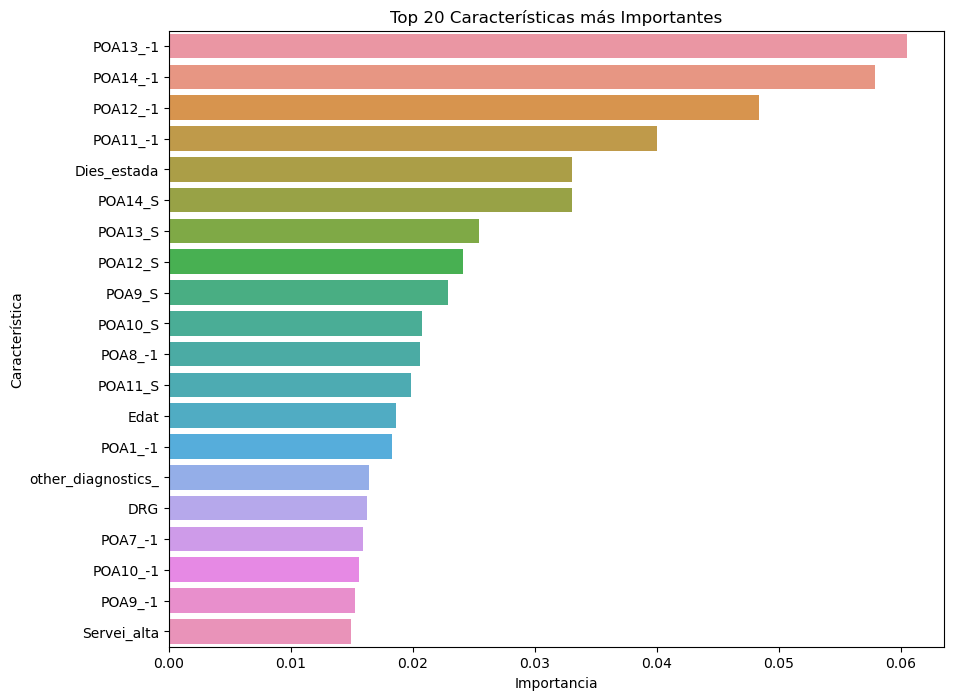

In [110]:
#### other RF model agrupant diagnostic i procediments

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos de los episodios sintéticos y los episodios modificados del dataset real
synthetic_data = pd.read_csv('episodios_sinteticos.csv', sep=';')
real_data = pd.read_csv('data_cluster.csv', sep=';')

# Seleccionar 1000 muestras aleatorias de los datos sintéticos y reales
synthetic_sample = synthetic_data.sample(n=1000, random_state=42).copy()
synthetic_sample['source'] = 'synthetic'  # Marcar los episodios sintéticos

real_sample = real_data.sample(n=1000, random_state=42).copy()
real_sample['source'] = 'real'  # Marcar los episodios reales

# Determinar columnas comunes entre los dos conjuntos de datos
common_columns = synthetic_sample.columns.intersection(real_sample.columns)

# Filtrar ambos conjuntos de datos para que solo contengan columnas comunes
synthetic_sample = synthetic_sample[common_columns]
real_sample = real_sample[common_columns]

# Verificación de las formas de los dataframes después de filtrar
print(f"Forma de la muestra sintética filtrada: {synthetic_sample.shape}")
print(f"Forma de la muestra real filtrada: {real_sample.shape}")

# Agrupar las columnas de diagnósticos DS01, DS02... en una sola columna 'other_diagnostics'
diagnosis_columns = [col for col in synthetic_sample.columns if col.startswith('DS')]
synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1)
real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1)

# Agrupar las columnas de tratamientos PS01, PS02... en una sola columna 'other_treatments'
treatment_columns = [col for col in synthetic_sample.columns if col.startswith('PS')]
synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1)
real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)), axis=1)

# Eliminar las columnas de diagnósticos, tratamientos y POA ya que las hemos agrupado
synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

# Eliminar también las columnas de POA (POA1, POA2...)
# poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
# synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
# real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

# Combinar los datos sintéticos y reales en un único DataFrame
combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)

# Crear columna objetivo: 1 para datos reales, 0 para sintéticos
combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

# Eliminar columnas innecesarias como 'source' y 'Id_pacient'
combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')

# Eliminar también las columnas de fechas
combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

# Imputar valores faltantes con un valor placeholder (por ejemplo, -1)
combined_data.fillna(-1, inplace=True)

# Convertir variables categóricas a variables dummy
encoded_data = pd.get_dummies(combined_data)

# Definir las características y la variable objetivo
X = encoded_data.drop(columns=['is_real'])
y = encoded_data['is_real']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

# Inicializar y entrenar el modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones con el modelo entrenado
y_pred = model.predict(X_test)

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

# Obtener la importancia de las características
feature_importance = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 20 características más importantes
print("Top 20 Características más Importantes:")
print(feature_importance.head(20))

# Visualización de la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Característica', data=feature_importance.head(20))
plt.title('Top 20 Características más Importantes')
plt.show()


C:\Users\34676\AppData\Local\Temp\ipykernel_14416\3004163418.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
c:\Users\34676\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\34676\AppData\Local\Temp\ipykernel_14416\3004163418.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
c:\Users\34676\anaconda3\Lib\site-packages\

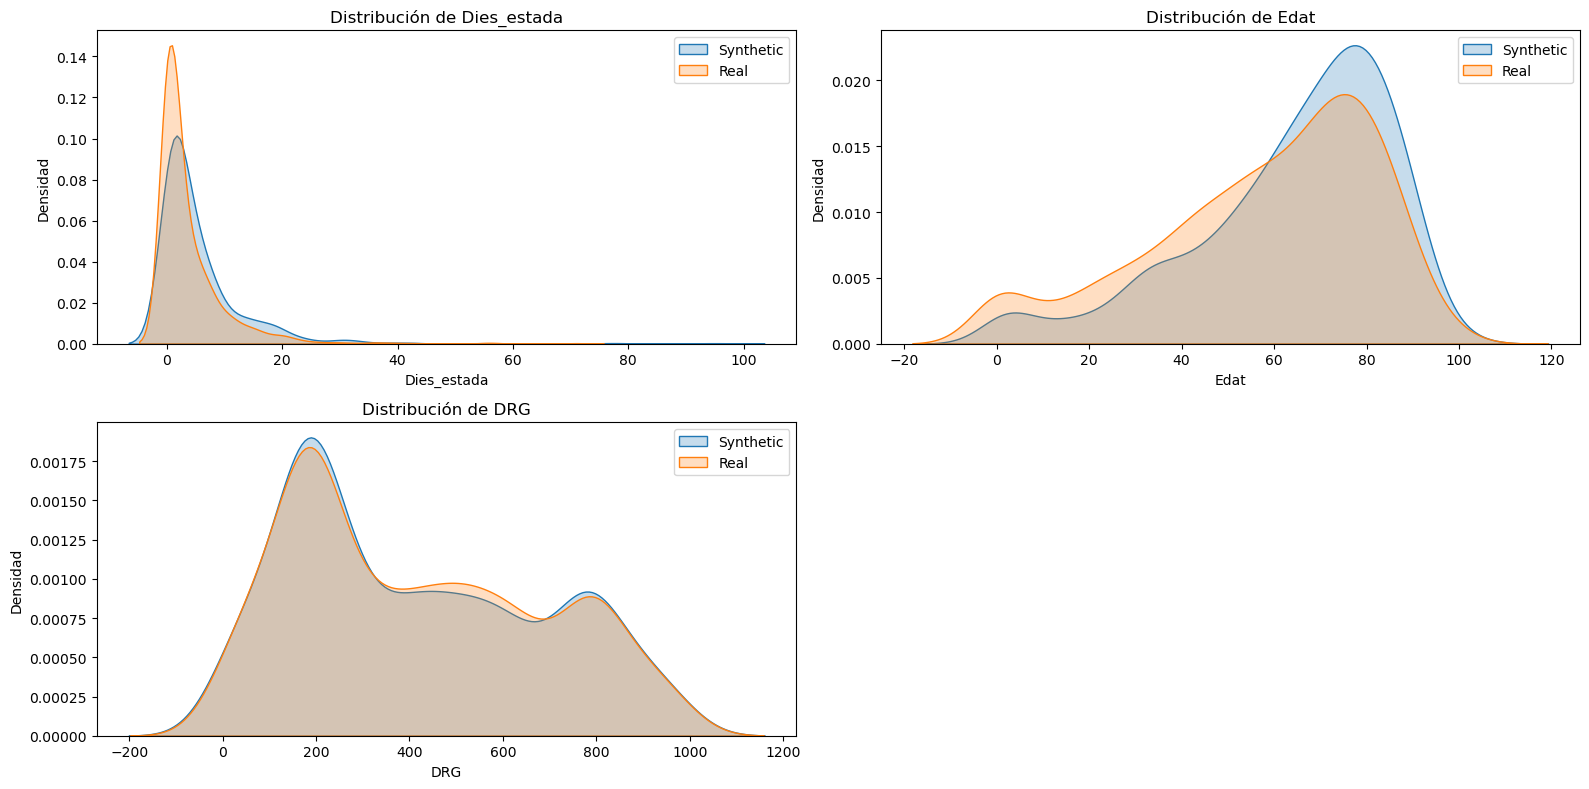

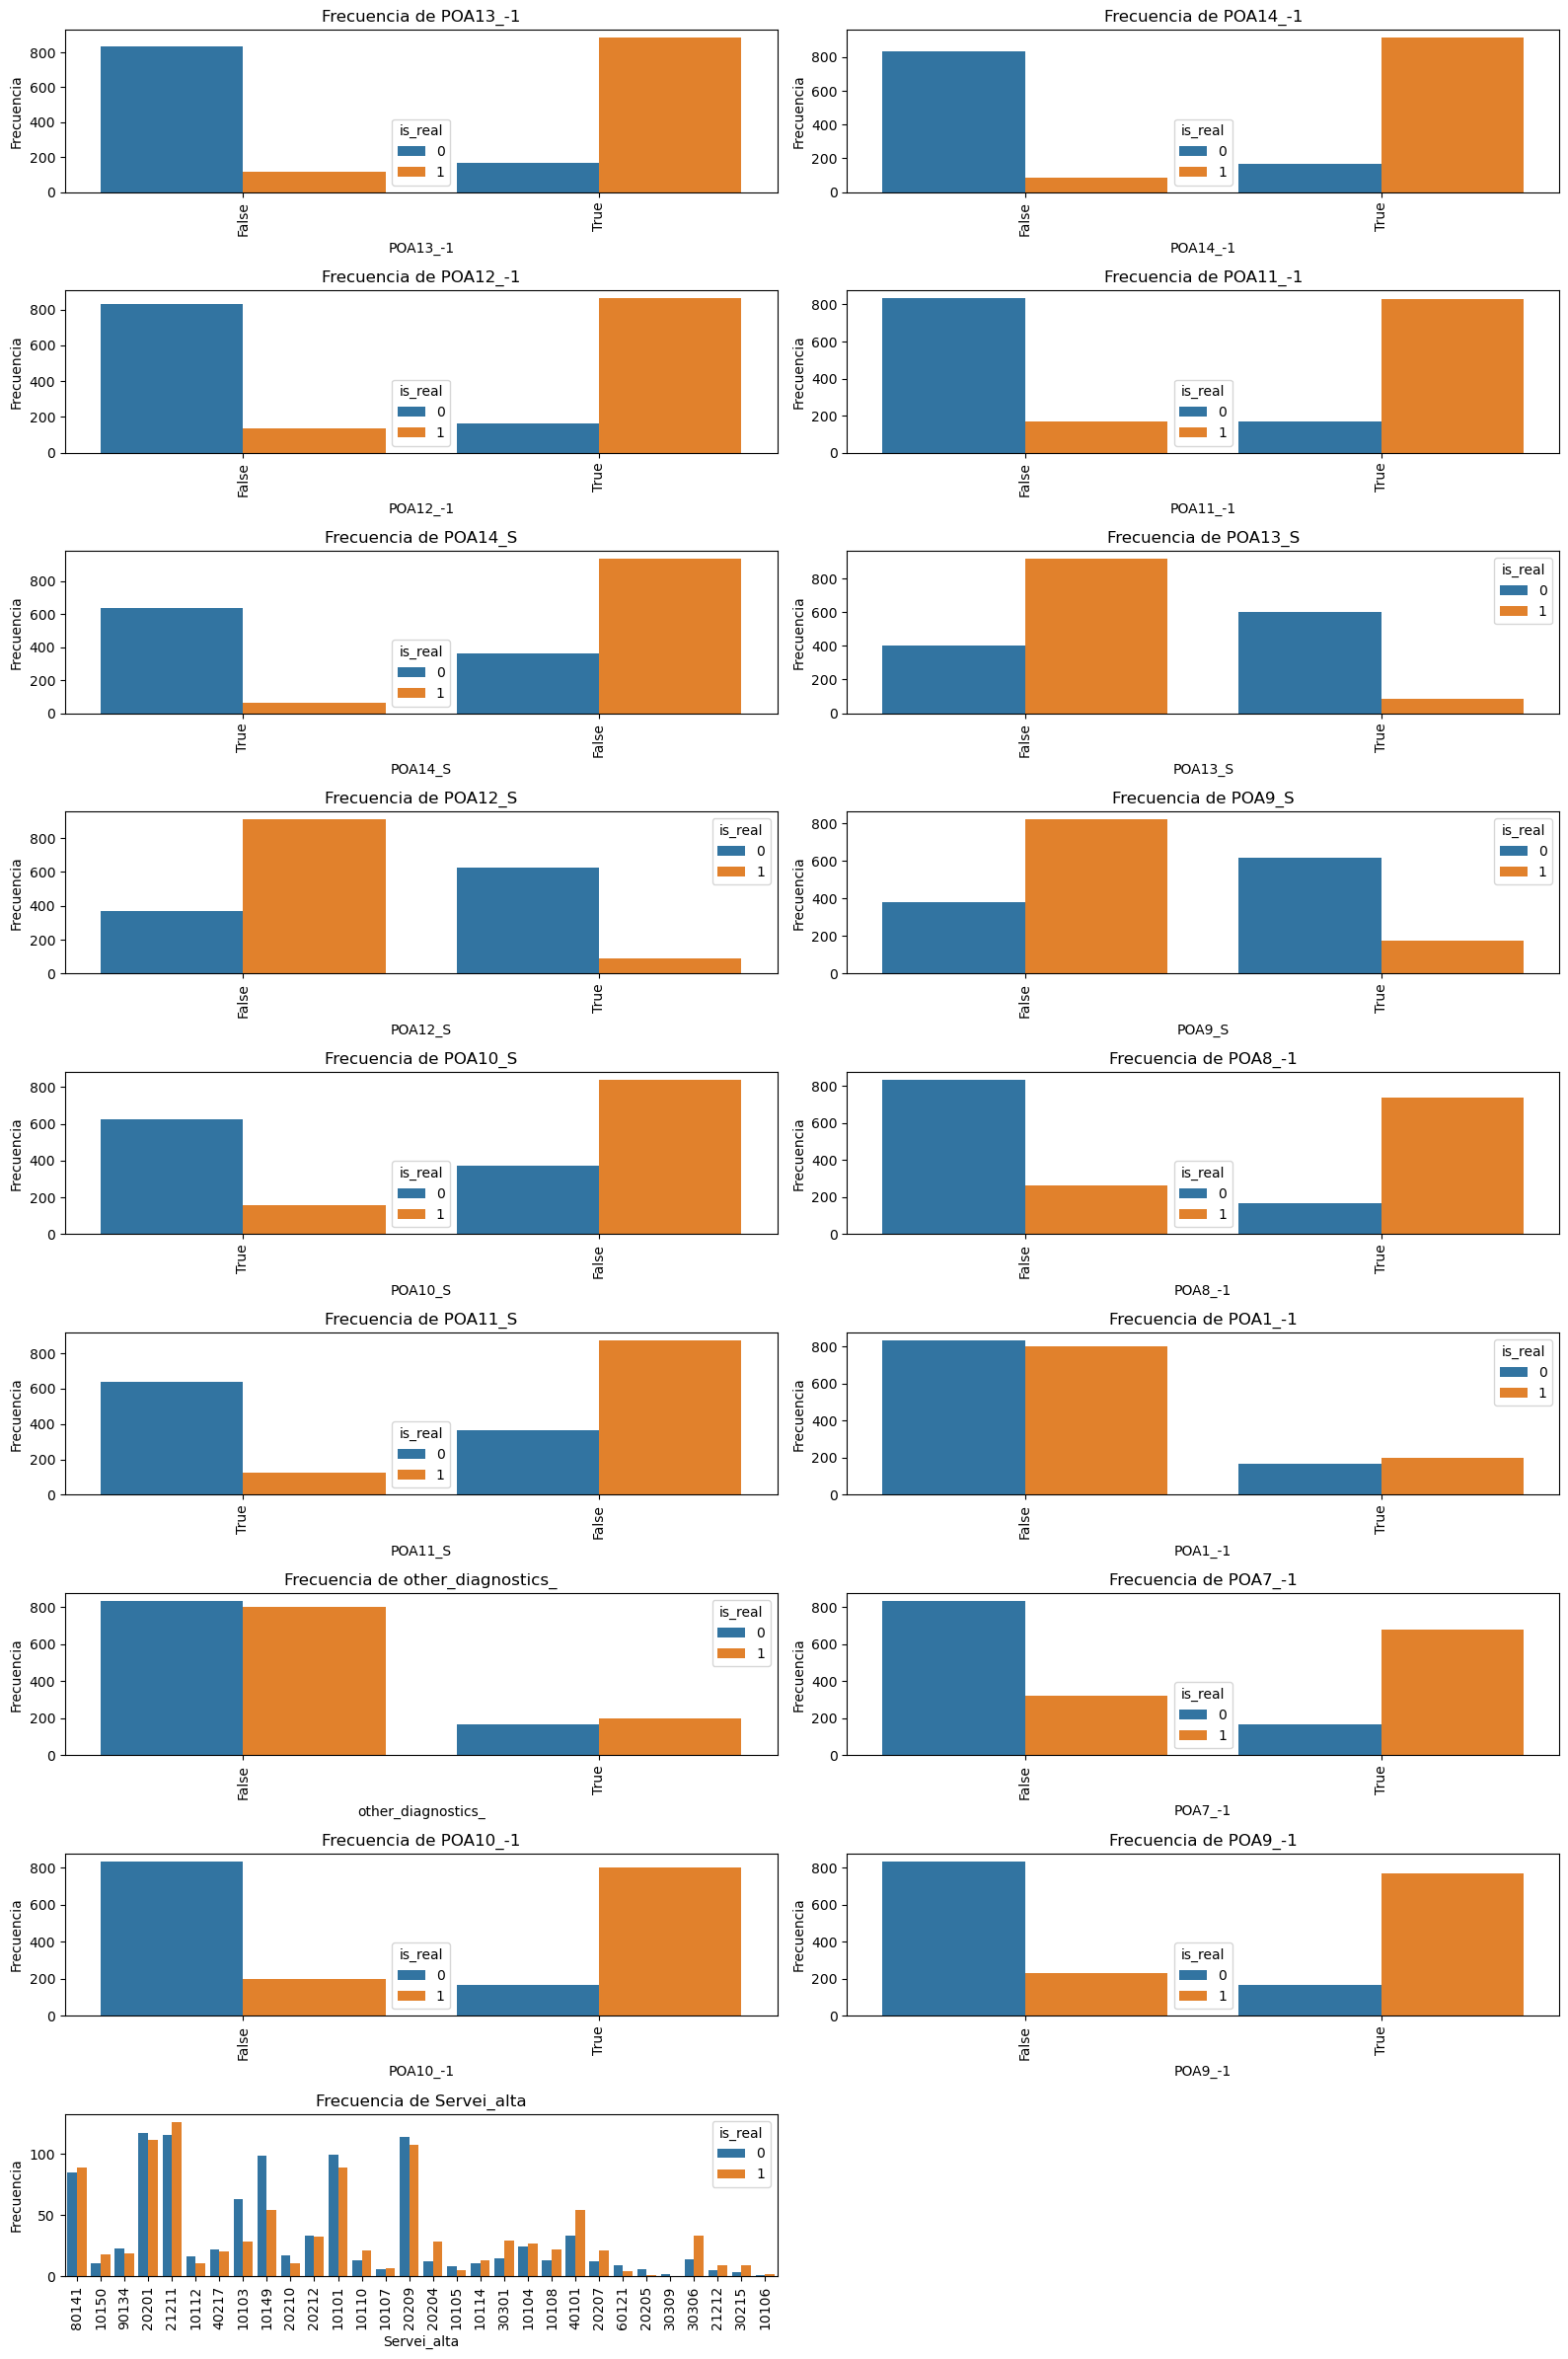

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegurarse de que las variables categóricas sean strings para Seaborn
encoded_data = encoded_data.astype(str)
encoded_data['is_real'] = encoded_data['is_real'].astype(str)

# Obtener la importancia de las características calculadas por RandomForest
# Suponiendo que ya tienes el DataFrame `feature_importance` calculado
# Añadimos 'Edat' si no está presente en el top de importancia
if 'Edat' not in feature_importance['Característica'].values:
    edat_row = pd.DataFrame({'Característica': ['Edat'], 'Importancia': [0]})
    feature_importance = pd.concat([feature_importance, edat_row], ignore_index=True)

# Tomar las 20 características más importantes
top_important_columns = feature_importance.head(20)['Característica'].tolist()

# Identificar automáticamente las variables continuas en 'encoded_data'
continuous_vars = encoded_data.select_dtypes(include=[np.number]).columns.tolist()
continuous_vars = ['Dies_estada', 'Edat', 'DRG']
# Asegurarse de que las variables categóricas sean aquellas que no son numéricas
categorical_vars = [col for col in top_important_columns if col not in continuous_vars]

# Filtrar el conjunto de datos solo con las columnas importantes que existan
filtered_data = encoded_data[[col for col in top_important_columns if col in encoded_data.columns] + ['is_real']]

# Verificar si hay variables continuas antes de graficar
if len(continuous_vars) > 0:
    # Crear subplots para las variables continuas en una cuadrícula de 2 columnas
    fig, axes = plt.subplots(nrows=(len(continuous_vars) + 1) // 2, ncols=2, figsize=(16, 8))

    # Asegurar que axes es un array plano para fácil indexación si hay solo una fila
    axes = axes.flatten()

    # Graficar las variables continuas
    for i, var in enumerate(continuous_vars):
        if var in filtered_data.columns:
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
            
            axes[i].set_title(f'Distribución de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Densidad')
            axes[i].legend()

    # Eliminar ejes no utilizados si hay más espacios en la cuadrícula de lo necesario
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No hay variables continuas para graficar.")

# Verificar si hay variables categóricas antes de graficar
if len(categorical_vars) > 0:
    # Crear subplots para las variables categóricas en una cuadrícula de 2 columnas
    fig, axes = plt.subplots(nrows=(len(categorical_vars) + 1) // 2, ncols=2, figsize=(16, 24))

    # Asegurar que axes es un array plano para fácil indexación si hay solo una fila
    axes = axes.flatten()

    # Graficar las variables categóricas
    for i, var in enumerate(categorical_vars):
        if var in filtered_data.columns:
            sns.countplot(data=filtered_data, x=var, hue='is_real', ax=axes[i])
            axes[i].set_title(f'Frecuencia de {var}')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frecuencia')

    # Eliminar ejes no utilizados si hay más espacios en la cuadrícula de lo necesario
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No hay variables categóricas para graficar.")

**Sin tener en cuenta POA**

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\69993177.py:11: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  real_data = pd.read_csv('data_cluster.csv', sep=';')


Forma de la muestra sintética filtrada: (1000, 61)
Forma de la muestra real filtrada: (1000, 61)
Matriz de Confusión:
[[255  47]
 [ 33 265]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       302
           1       0.85      0.89      0.87       298

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600

Top 20 Características más Importantes:
                                      Característica  Importancia
5                                        Dies_estada     0.059804
0                                               Edat     0.048073
6                                        Servei_alta     0.044855
7                                                DRG     0.044388
8                                          T. asist.     0.033093
2                                        Circ_admiss     0.017318
440

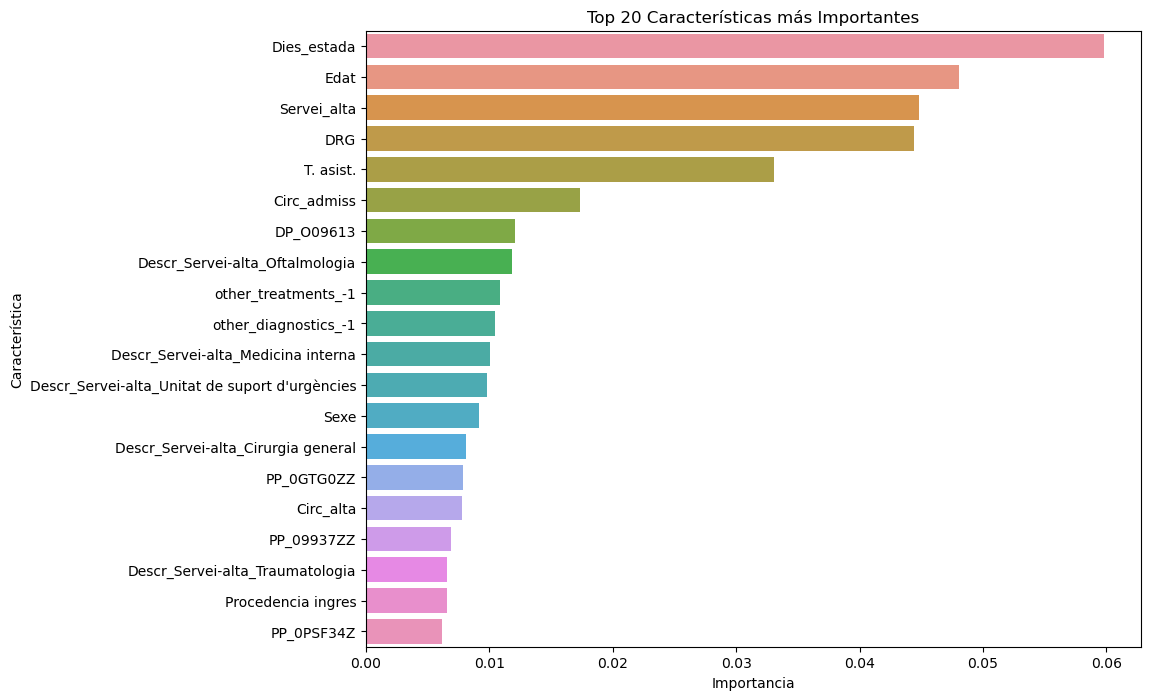

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos de los episodios sintéticos y los episodios modificados del dataset real
synthetic_data = pd.read_csv('episodios_sinteticos.csv', sep=';')
real_data = pd.read_csv('data_cluster.csv', sep=';')

# Seleccionar 1000 muestras aleatorias de los datos sintéticos y reales
synthetic_sample = synthetic_data.sample(n=1000, random_state=47).copy()
synthetic_sample['source'] = 'synthetic'  # Marcar los episodios sintéticos

real_sample = real_data.sample(n=1000, random_state=49).copy()
real_sample['source'] = 'real'  # Marcar los episodios reales

# Determinar columnas comunes entre los dos conjuntos de datos
common_columns = synthetic_sample.columns.intersection(real_sample.columns)

# Filtrar ambos conjuntos de datos para que solo contengan columnas comunes
synthetic_sample = synthetic_sample[common_columns]
real_sample = real_sample[common_columns]

# Verificación de las formas de los dataframes después de filtrar
print(f"Forma de la muestra sintética filtrada: {synthetic_sample.shape}")
print(f"Forma de la muestra real filtrada: {real_sample.shape}")

# Agrupar las columnas de diagnósticos DS01, DS02... en una sola columna 'other_diagnostics'
diagnosis_columns = [col for col in synthetic_sample.columns if col.startswith('DS')]
synthetic_sample['other_diagnostics'] = synthetic_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_diagnostics'] = real_sample[diagnosis_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Agrupar las columnas de tratamientos PS01, PS02... en una sola columna 'other_treatments'
treatment_columns = [col for col in synthetic_sample.columns if col.startswith('PS')]
synthetic_sample['other_treatments'] = synthetic_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)
real_sample['other_treatments'] = real_sample[treatment_columns].apply(lambda row: ','.join(row.dropna().astype(str)) if row.notna().any() else np.nan, axis=1)

# Eliminar las columnas de diagnósticos, tratamientos y POA ya que las hemos agrupado
synthetic_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)
real_sample.drop(columns=diagnosis_columns + treatment_columns, inplace=True)

# Eliminar las columnas de POA (POA1, POA2...) ya que no las queremos considerar
poa_columns = [col for col in synthetic_sample.columns if col.startswith('POA')]
synthetic_sample.drop(columns=poa_columns, inplace=True, errors='ignore')
real_sample.drop(columns=poa_columns, inplace=True, errors='ignore')

# Combinar los datos sintéticos y reales en un único DataFrame
combined_data = pd.concat([synthetic_sample, real_sample], ignore_index=True)

# Crear columna objetivo: 1 para datos reales, 0 para sintéticos
combined_data['is_real'] = combined_data['source'].map({'real': 1, 'synthetic': 0})

# Eliminar columnas innecesarias como 'source' y 'Id_pacient'
combined_data.drop(columns=['source', 'Id_pacient'], inplace=True, errors='ignore')

# Eliminar también las columnas de fechas
combined_data.drop(columns=['Data_naix', 'Data_ingres', 'Data_alta', 'cluster'], inplace=True, errors='ignore')

# Imputar valores faltantes con un valor placeholder (por ejemplo, -1)
combined_data.fillna(-1, inplace=True)

# Convertir variables categóricas a variables dummy
encoded_data = pd.get_dummies(combined_data)

# Definir las características y la variable objetivo
X = encoded_data.drop(columns=['is_real'])
y = encoded_data['is_real']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar y entrenar el modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones con el modelo entrenado
y_pred = model.predict(X_test)

# Evaluación del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

# Obtener la importancia de las características
feature_importance = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 20 características más importantes
print("Top 20 Características más Importantes:")
print(feature_importance.head(20))

# Visualización de la importancia de las características
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Característica', data=feature_importance.head(20))
plt.title('Top 20 Características más Importantes')
plt.show()


**Visualización de estos features en el set de datos seleccionado real/sintetico**

C:\Users\34676\AppData\Local\Temp\ipykernel_14416\186563089.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
c:\Users\34676\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\34676\AppData\Local\Temp\ipykernel_14416\186563089.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
c:\Users\34676\anaconda3\Lib\site-packages\se

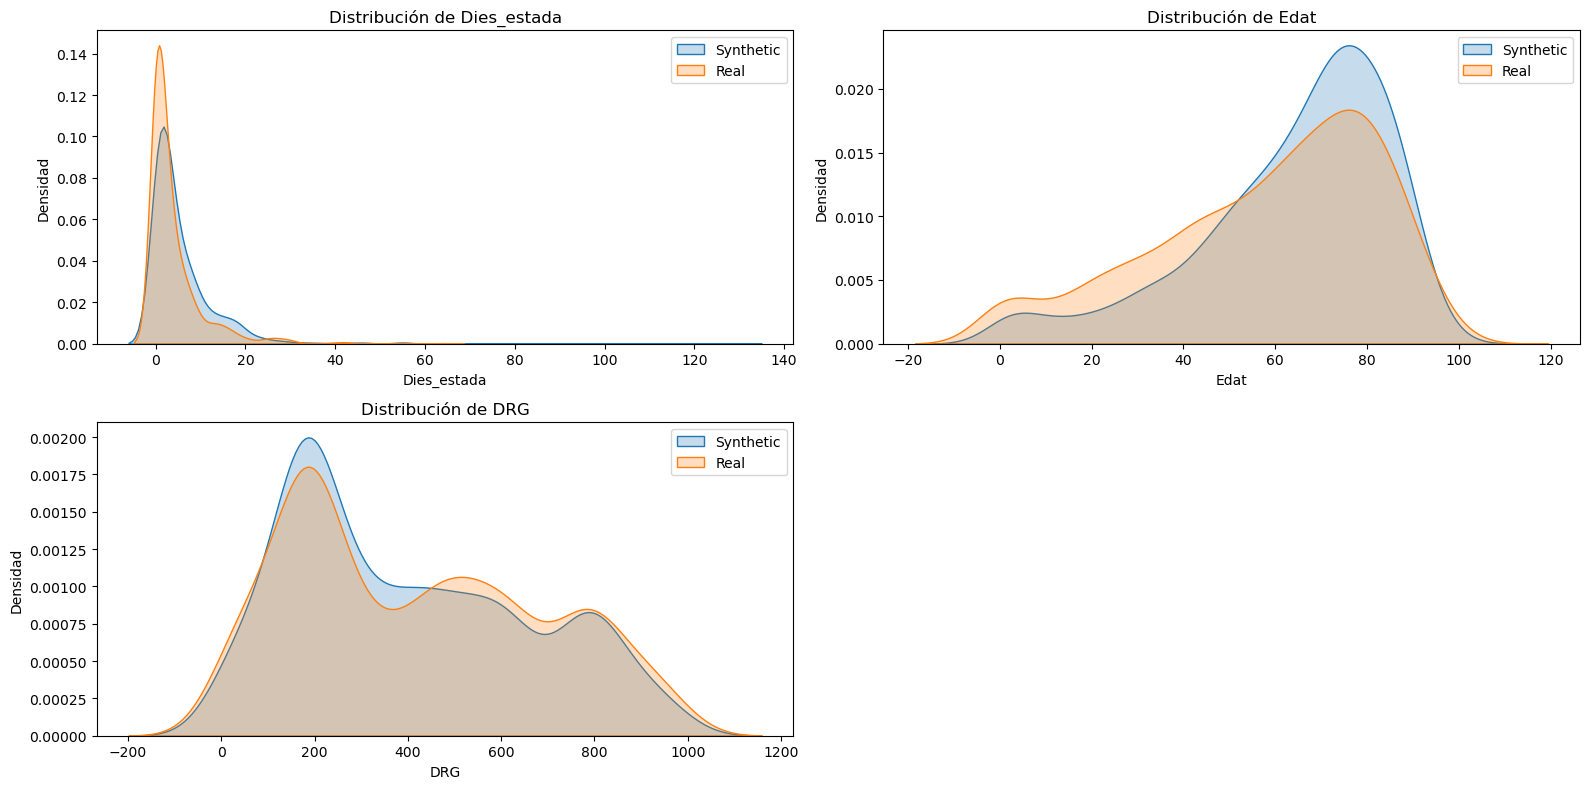

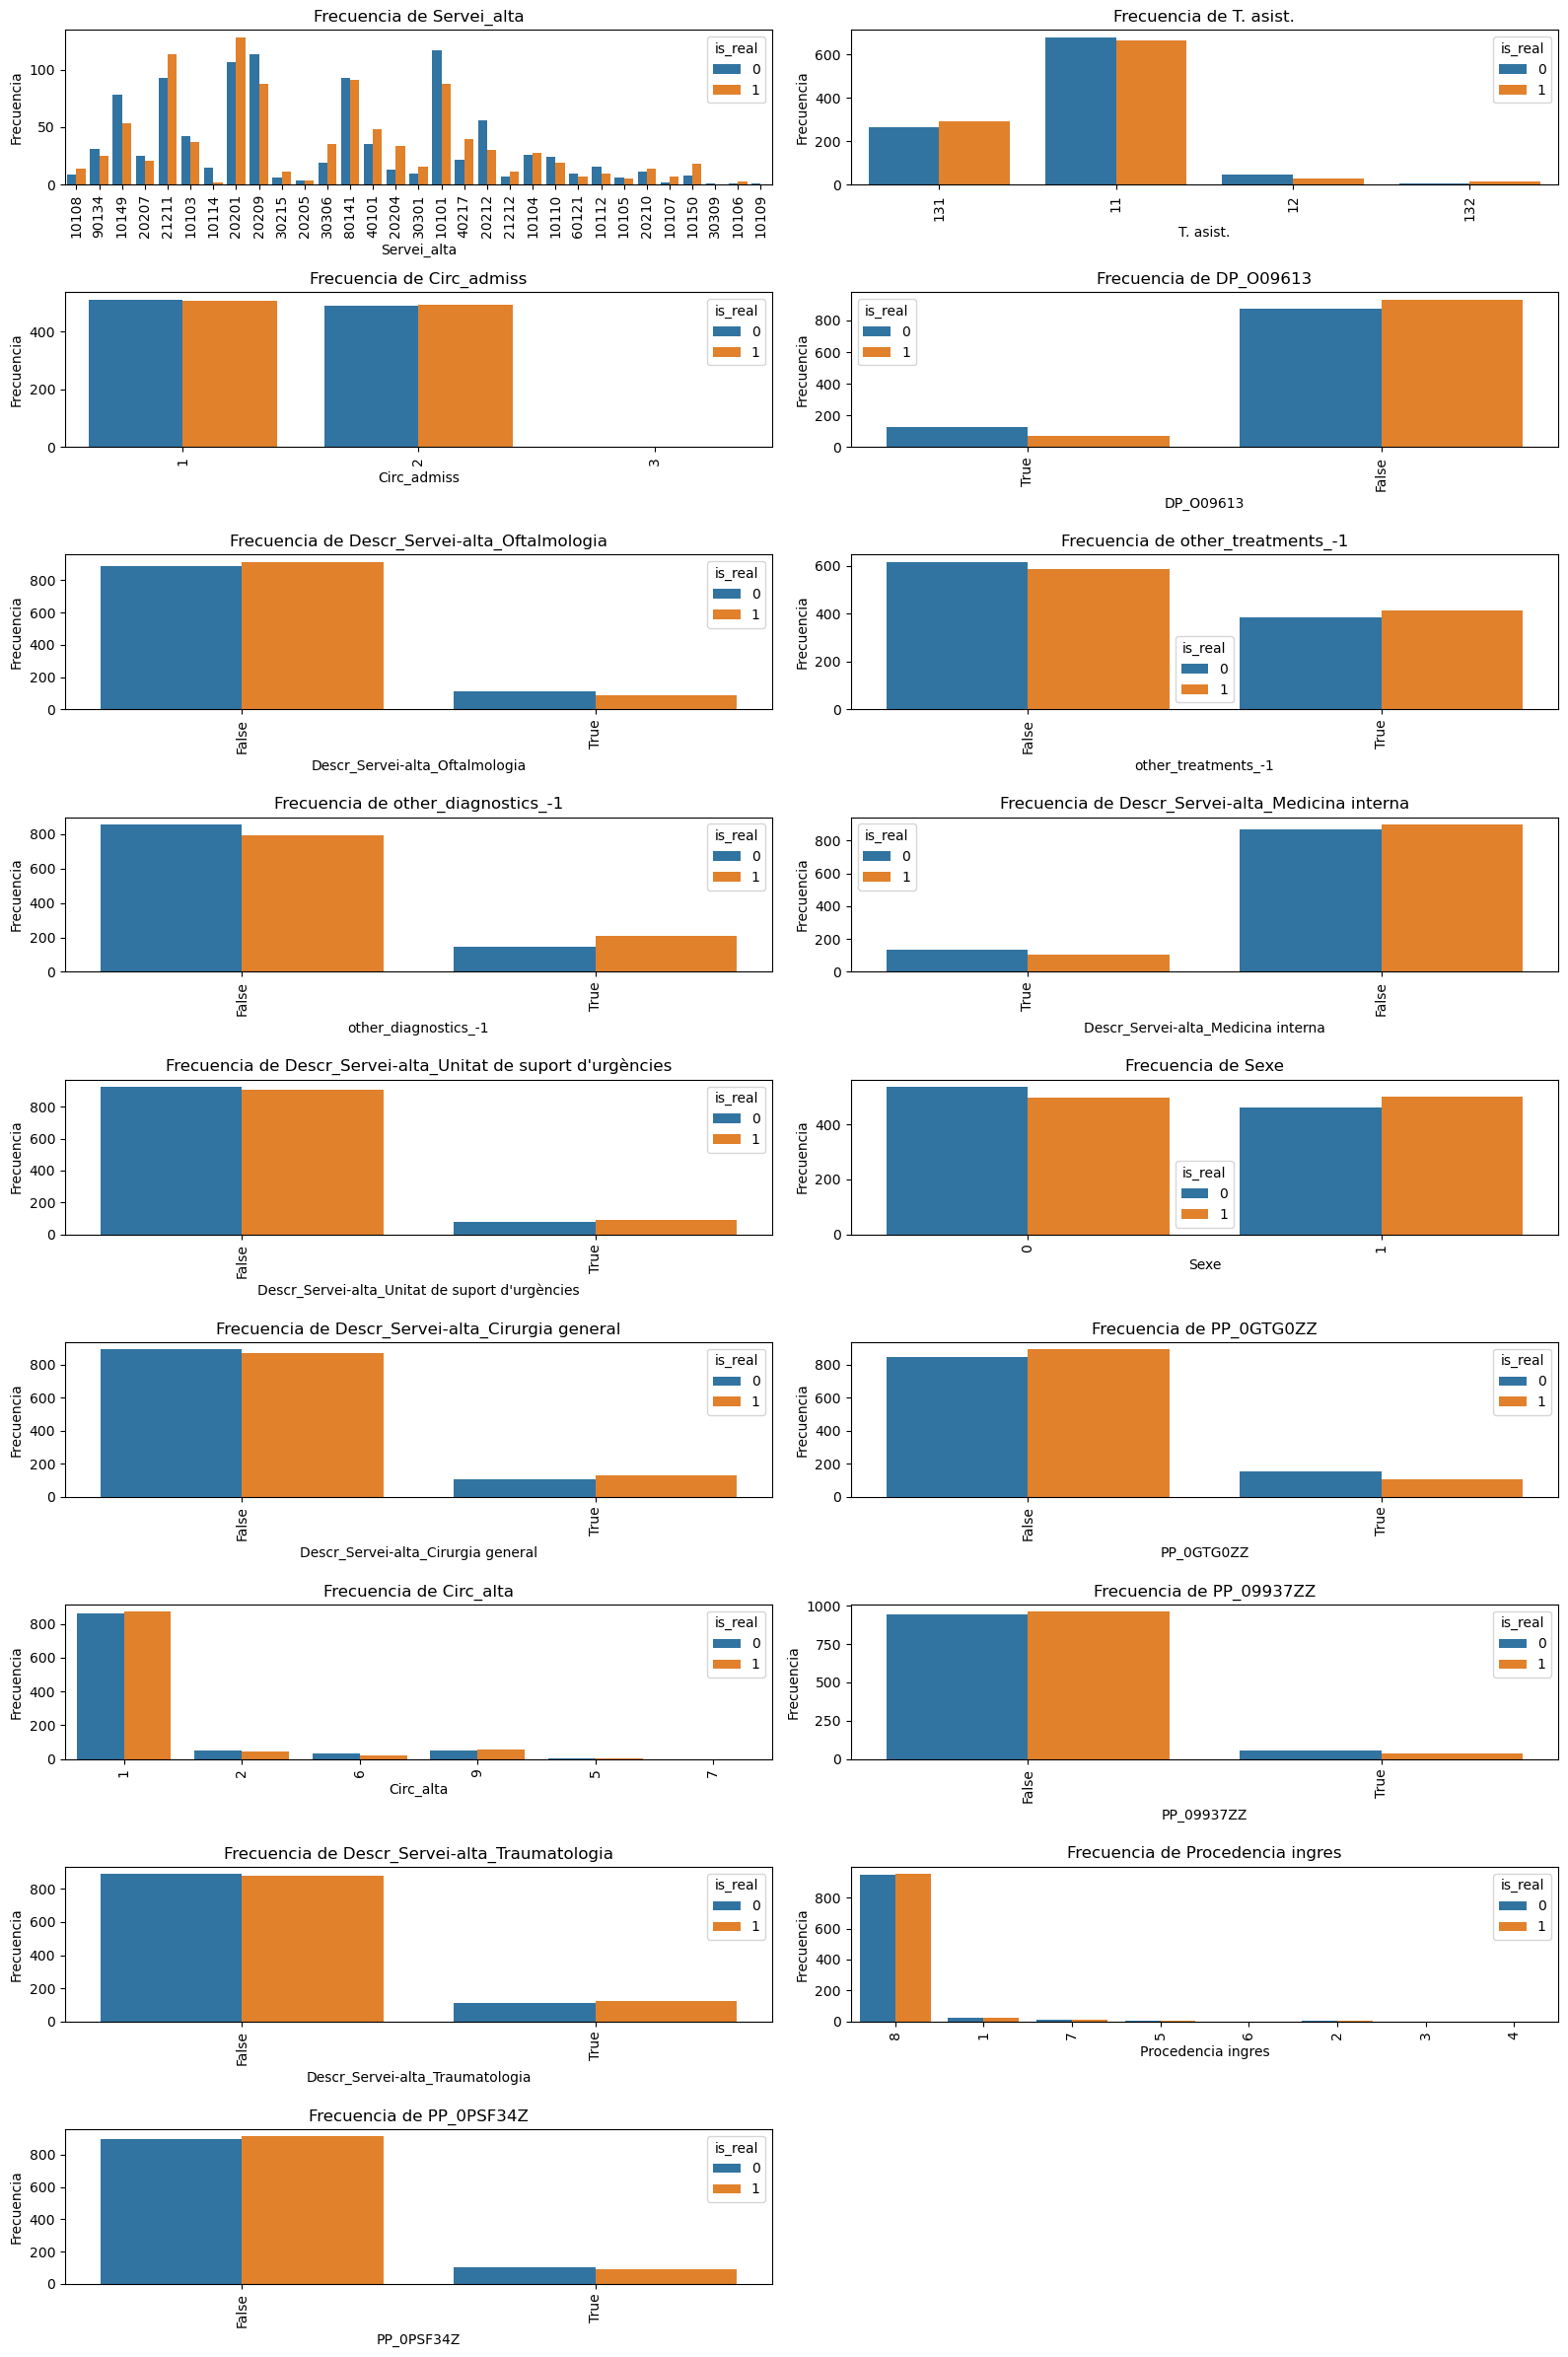

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asegurarse de que las variables categóricas sean strings para Seaborn
encoded_data = encoded_data.astype(str)
encoded_data['is_real'] = encoded_data['is_real'].astype(str)

# Obtener la importancia de las características calculadas por RandomForest
# Suponiendo que ya tienes el DataFrame `feature_importance` calculado
# Añadimos 'Edat' si no está presente en el top de importancia
if 'Edat' not in feature_importance['Característica'].values:
    edat_row = pd.DataFrame({'Característica': ['Edat'], 'Importancia': [0]})
    feature_importance = pd.concat([feature_importance, edat_row], ignore_index=True)

# Tomar las 20 características más importantes
top_important_columns = feature_importance.head(20)['Característica'].tolist()

# Identificar automáticamente las variables continuas en 'encoded_data'
continuous_vars = encoded_data.select_dtypes(include=[np.number]).columns.tolist()
continuous_vars = ['Dies_estada', 'Edat', 'DRG']
# Asegurarse de que las variables categóricas sean aquellas que no son numéricas
categorical_vars = [col for col in top_important_columns if col not in continuous_vars]

# Filtrar el conjunto de datos solo con las columnas importantes que existan
filtered_data = encoded_data[[col for col in top_important_columns if col in encoded_data.columns] + ['is_real']]

# Verificar si hay variables continuas antes de graficar
if len(continuous_vars) > 0:
    # Crear subplots para las variables continuas en una cuadrícula de 2 columnas
    fig, axes = plt.subplots(nrows=(len(continuous_vars) + 1) // 2, ncols=2, figsize=(16, 8))

    # Asegurar que axes es un array plano para fácil indexación si hay solo una fila
    axes = axes.flatten()

    # Graficar las variables continuas
    for i, var in enumerate(continuous_vars):
        if var in filtered_data.columns:
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '0'][var].astype(float), ax=axes[i], label='Synthetic', shade=True)
            sns.kdeplot(filtered_data[filtered_data['is_real'] == '1'][var].astype(float), ax=axes[i], label='Real', shade=True)
            
            axes[i].set_title(f'Distribución de {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Densidad')
            axes[i].legend()

    # Eliminar ejes no utilizados si hay más espacios en la cuadrícula de lo necesario
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No hay variables continuas para graficar.")

# Verificar si hay variables categóricas antes de graficar
if len(categorical_vars) > 0:
    # Crear subplots para las variables categóricas en una cuadrícula de 2 columnas
    fig, axes = plt.subplots(nrows=(len(categorical_vars) + 1) // 2, ncols=2, figsize=(16, 24))

    # Asegurar que axes es un array plano para fácil indexación si hay solo una fila
    axes = axes.flatten()

    # Graficar las variables categóricas
    for i, var in enumerate(categorical_vars):
        if var in filtered_data.columns:
            sns.countplot(data=filtered_data, x=var, hue='is_real', ax=axes[i])
            axes[i].set_title(f'Frecuencia de {var}')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frecuencia')

    # Eliminar ejes no utilizados si hay más espacios en la cuadrícula de lo necesario
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No hay variables categóricas para graficar.")
